In [2]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split

import matplotlib.pyplot as plt
from PIL import Image

import os
import random
from pathlib import Path
import pathlib
from typing import Tuple, Dict, List

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_test_timer(start, end, device):
  total_time = end - start
  print(f"Waktu training menggunakan {device}: {total_time} second")
  return total_time



In [4]:
try:
  import torchinfo
  import facenet_pytorch
except:
  !pip install torchinfo
  !pip install facenet-pytorch
  import torchinfo
  import facenet_pytorch

from facenet_pytorch import MTCNN, InceptionResnetV1
from torchinfo import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00


### Transformation

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

### Load dan download data dari direktori

In [6]:
direktori_lfw_py = Path("data/lfw-py")
direktori_gambar = direktori_lfw_py / "lfw_funneled"

In [7]:
tenfold_dataset = datasets.LFWPeople(root="data",
                                  split="10fold", # Keseluruhan data tanpa di bagi
                                  download=True)

100%|██████████| 243346528/243346528 [01:54<00:00, 2119232.52it/s]


Extracting data/lfw-py/lfw-funneled.tgz to data/lfw-py


100%|██████████| 94770/94770 [00:00<00:00, 968404.44it/s]


100%|██████████| 94727/94727 [00:00<00:00, 1375259.47it/s]


### Bikin function temukan class

In [8]:
def temukan_class(direktori: str) -> Tuple[List[str], Dict[str, int]]:
  """ Temukan class dataset berdasarkan nama folder dari masing masing gambar dataset"""
  classes = sorted(entry.name for entry in os.scandir(direktori) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Tidak dapat menemukan class apapun di {direktori}... Coba cek lagi sturktur file atau direktori")
  return classes

class_names = temukan_class(direktori_gambar)
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

output_shape = len(class_names)
# class_names, class_to_idx

### Split data train dan test

In [9]:
train_size = int(0.2 * len(tenfold_dataset))
test_size = len(tenfold_dataset) - train_size

train_data, test_data = random_split(tenfold_dataset, [test_size, train_size])

len(train_data), len(test_data)

(10587, 2646)

In [10]:
class CustomLFWDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]


        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        if self.transform:
            img_tensor = self.transform(img)
            return img_tensor, label
        else:
            return img, label


In [11]:
train_dataset = CustomLFWDataset(train_data,
                              transform=train_transform)

test_dataset = CustomLFWDataset(test_data,
                             transform=test_transform)

tenfold_dataset = CustomLFWDataset(tenfold_dataset,
                                   transform = test_transform)

### Pahami dataset

In [12]:
img, label = train_dataset[71][0], train_dataset[71][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image Datatype: torch.float32
Image label: 5599
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute: torch.Size([224, 224, 3]) -> [height, width, color_channerls]


Text(0.5, 1.0, 'Wayne_Brady')

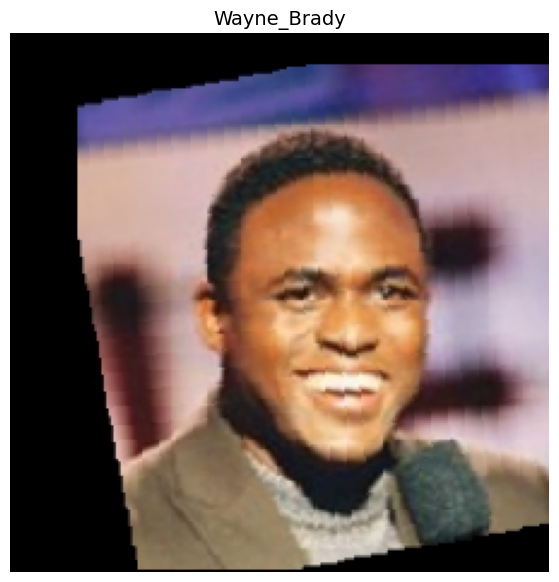

In [13]:
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channerls]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [14]:
def display_random_image(dataset: torch.utils.data.dataset.Dataset,
                         classes,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int=None):
  if n > 10:
    n = 10
    display_shape = False
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 16))

  for i, target_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
        title = f"class: {classes[targ_label]}"
        if display_shape:
            title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

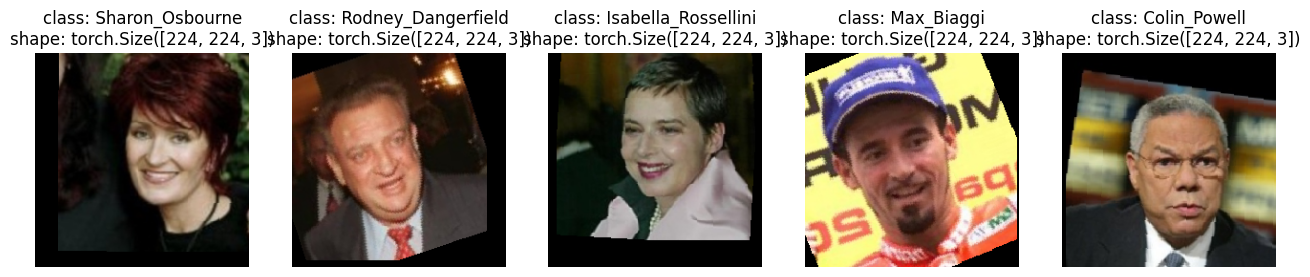

In [15]:
display_random_image(train_dataset,
                     n = 5,
                     classes = class_names)

### Bikin Dataloader

In [16]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

test_dataloader = DataLoader(test_dataset,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f10c2063d60>, <torch.utils.data.dataloader.DataLoader object at 0x7f10c24b7850>)
Length of train dataloader: 166 batches of 64
Length of test dataloader: 42 batches of 64


In [17]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Dataloaders features:{train_features_batch}")
print(f"\nDataloaders features shape:{train_features_batch.shape}")
print(f"\nDataloaders features dtype:{train_features_batch.dtype}")


print(f"\ndataloaders lables: {train_labels_batch}")
print(f"\ndataloaders lables shape: {train_labels_batch.shape}")
print(f"\ndataloaders lables dtype: {train_labels_batch.dtype}")

Dataloaders features:tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.

### Bikin subset dari dataset

In [18]:
train_indices = list(range(4000))
test_indices = list(range(1000))


train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

len(train_subset), len(train_dataset), len(test_subset), len(test_dataset)

(4000, 10587, 1000, 2646)

In [19]:
BATCH_SIZE_SUBSET = 32
train_subset_dataloader = DataLoader(train_subset,
                              batch_size = BATCH_SIZE_SUBSET,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

test_subset_dataloader = DataLoader(test_subset,
                             batch_size = BATCH_SIZE_SUBSET,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

### Bikin fungsi train dan test step dan satuin

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X) # output model logits

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,  0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [22]:
def latihan(model: torch.nn.Module,
            train_dataloader,
            test_dataloader,
            optimizer,
            loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
            epochs: int = 5,
            device = device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### Bikin fungsi plot untuk nilai loss

In [23]:
def plot_loss_kurva(hasil_latihan: Dict[str, list[float]]):
  loss = hasil_latihan["train_loss"]
  test_loss = hasil_latihan["test_loss"]

  accuracy = hasil_latihan["train_acc"]
  test_acc = hasil_latihan["test_acc"]

  epochs = range(len(hasil_latihan["train_loss"]))

  plt.figure(figsize = (15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_acc, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

### Model Facenet-pytorch

In [24]:
class FaceClassifier(nn.Module):
    def __init__(self, out_features):
        super(FaceClassifier, self).__init__()
        self.facenet = model_facenet
        self.classifier = nn.Linear(512, out_features)

    def forward(self, x):
        x = self.facenet(x)
        x = self.classifier(x)
        return x

In [25]:
mtcnn = MTCNN(keep_all=True, device=device)
model_facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [26]:
model_1 = FaceClassifier(output_shape).to(device)

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

In [ ]:
epochs = 10

train_time_start_model_1 = timer()

latihan_model_1 = latihan(model = model_1,
                          train_dataloader = train_dataloader,
                          test_dataloader = test_dataloader,
                          loss_fn = loss_fn,
                          optimizer = optimizer,
                          device = device,
                          epochs = epochs
                        )

train_time_end_model_1 = timer()
train_test_timer(start = train_time_start_model_1,
                 end = train_time_end_model_1,
                 device = str(next(model_1.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plot_loss_kurva(latihan_model_1)

### Model vgg16

In [ ]:
from torchvision.models import vgg16, VGG16_Weights
model_2 = vgg16(pretrained = False)

model_2.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias=True),  # Sesuaikan dengan input features dari VGG16
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(4096, 4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(4096, output_shape)  # Sesuaikan dengan jumlah kelas yang sesuai
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.classifier.parameters(),
                             lr=0.001,
                             )

In [ ]:
epochs = 10

train_time_start_model_2 = timer()

latihan_model_2 = latihan(model = model_2,
                          train_dataloader = train_dataloader,
                          test_dataloader = test_dataloader,
                          loss_fn = loss_fn,
                          optimizer = optimizer,
                          device = device,
                          epochs = epochs
                        )

train_time_end_model_2 = timer()
train_test_timer(start = train_time_start_model_2,
                 end = train_time_end_model_2,
                 device = str(next(model_2.parameters()).device))